In [136]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import joblib

## Load Data

In [2]:
train_clean = joblib.load('data/train_clean.pckl')
test_clean = joblib.load('data/test_clean.pckl')

#X = joblib.load('data/X.pckl')
X_tfidf = joblib.load('data/X_tfidf.pckl')
X_svd = joblib.load('data/X_svd.pckl')

#X_test = joblib.load('data/X_test.pckl')
X_test_tfidf = joblib.load('data/X_test_tfidf.pckl')
X_test_svd = joblib.load('data/X_test_svd.pckl')

In [51]:
# Create data sets to hold CV predictions on training data for stacked model fit

stack_train = train_clean[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate']].copy()

## Create Folds to Use Across Methods

In [4]:
from sklearn.model_selection import StratifiedKFold

In [20]:
skf = StratifiedKFold(n_splits=10, random_state=678246569, shuffle=True)

## Naive Bayes

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc

In [55]:
model = 'NB'
mbayes = MultinomialNB()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        mbayes.fit(X_tfidf[train, :], train_clean.loc[train, target])
        preds = mbayes.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]
        
#         fpr, tpr, thresholds = roc_curve(train_clean.loc[test, target], preds[:,1], pos_label=1)
#         roc_auc = auc(fpr, tpr)
#         print(roc_auc)

In [56]:
stack_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,NB_toxic,NB_severe_toxic,NB_obscene,NB_threat,NB_insult,NB_identity_hate
0,0000997932d777bf,0,0,0,0,0,0,0.000072,1.523027e-07,0.000008,2.718901e-08,0.000008,1.345856e-07
1,000103f0d9cfb60f,0,0,0,0,0,0,0.000916,1.319286e-05,0.000212,2.449853e-06,0.000157,9.285133e-06
2,000113f07ec002fd,0,0,0,0,0,0,0.000098,5.031757e-08,0.000009,5.857017e-09,0.000006,4.529827e-08
3,0001b41b1c6bb37e,0,0,0,0,0,0,0.000012,2.935742e-08,0.000002,5.856117e-09,0.000002,3.401068e-08
4,0001d958c54c6e35,0,0,0,0,0,0,0.015519,2.742424e-04,0.005280,7.348771e-05,0.004632,2.977539e-04


## Regularized Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [59]:
model = 'LOG'

final_c = {'toxic':20,
           'severe_toxic':2,
           'obscene':9,
           'threat':11,
           'insult':7,
           'identity_hate':9}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        log = LogisticRegression(C=final_c[target]).fit(X_tfidf[train,:], train_clean.loc[train, target])
        preds = log.predict_proba(X_tfidf[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

        fpr, tpr, thresholds = roc_curve(train_clean.loc[test, target], preds[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)

0.970228821591
0.973301890297
0.973065852346
0.975765056508
0.973154173186
0.976077667996
0.97156889001
0.971825726625
0.973534131352
0.973611651143
0.987962479428
0.986142233194
0.986063307064
0.986229862957
0.988199060008
0.988173011312
0.989661081258
0.98330289606
0.98810418187
0.983853514102
0.987433288556
0.989021481956
0.988254915565
0.987925658045
0.987172152073
0.987952322853
0.987434649685
0.986116914807
0.98531489533
0.988787785797
0.989011104127
0.988779331657
0.982724439556
0.987404928028
0.986682066755
0.989244819494
0.971712814549
0.989709703103
0.985272621011
0.965895124264
0.979210320262
0.978883315654
0.980071541146
0.974736488996
0.976147293789
0.974646395116
0.980080015581
0.980239199136
0.979940824274
0.980782464203
0.973125916679
0.980623460618
0.976150088983
0.982252464693
0.977734253969
0.976937111065
0.985242340487
0.976848941397
0.977564762627
0.982457412024


In [60]:
joblib.dump(stack_train, 'data/stacking_train_scores.pckl')

['data/stacking_train_scores.pckl']

## LDA w/ SVD Decomp

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [63]:
model = 'LDA'

final_shrinkage = {'toxic': .4,
                   'severe_toxic': .8,
                   'obscene': .5,
                   'threat': .8,
                   'insult': .5,
                   'identity_hate': .7}

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:

    stack_train[model+'_'+target] = np.nan

    for train, test in skf.split(X_tfidf, train_clean[target]):
        lda = LinearDiscriminantAnalysis(shrinkage=final_shrinkage[target], solver='eigen')
        lda.fit(X_svd[train, :], train_clean.loc[train, target])
        preds = lda.predict_proba(X_svd[test, :])
        stack_train.loc[test, model+'_'+target] = preds[:,1]

In [64]:
stack_train.head().transpose()

,0,1,2,3,4
id,0000997932d777bf,000103f0d9cfb60f,000113f07ec002fd,0001b41b1c6bb37e,0001d958c54c6e35
toxic,0,0,0,0,0
severe_toxic,0,0,0,0,0
obscene,0,0,0,0,0
threat,0,0,0,0,0
insult,0,0,0,0,0
identity_hate,0,0,0,0,0
NB_toxic,7.18358e-05,0.000915659,9.83415e-05,1.20258e-05,0.0155186
NB_severe_toxic,1.52303e-07,1.31929e-05,5.03176e-08,2.93574e-08,0.000274242
NB_obscene,7.73267e-06,0.000211522,8.72534e-06,2.0504e-06,0.00527961


## Stacking

In [122]:
s1 = pd.read_csv('data/S1_baselineNB.csv')
s3 = pd.read_csv('data/S3_lda_svd.csv')
s4 = pd.read_csv('data/S4_logistic_tuned.csv')

In [96]:
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler

In [108]:
# create target level X df's with standardized features, and saved scaler transformers

x_dfs = dict()
m_list = ['NB_', 'LOG_', 'LDA_']

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = stack_train[[item+target for item in m_list]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    x_dfs[target] = scaler, X_scaled

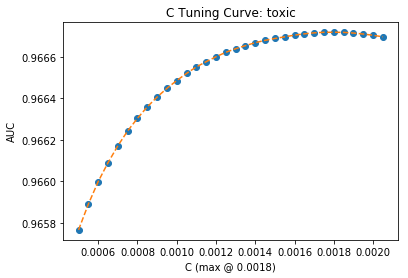

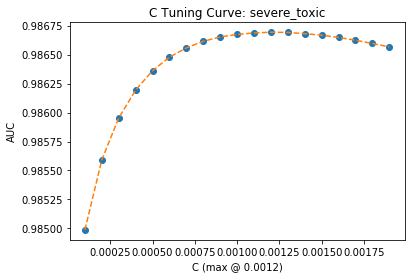

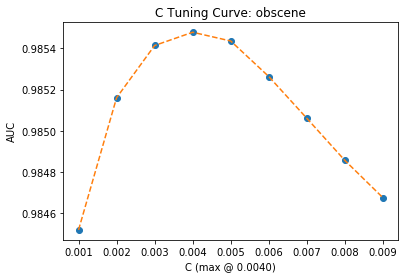

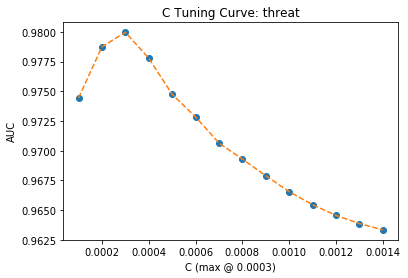

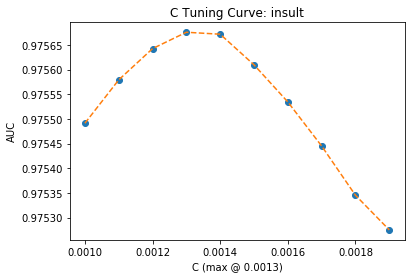

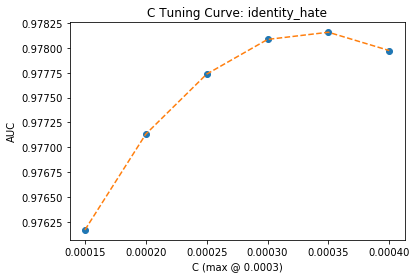

In [121]:
# tune C params for regularized logistic stacked model

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(fit_intercept=False)

    params = {'toxic'           : {'C': np.arange(.0005,.0021,.00005)},
              'severe_toxic'    : {'C': np.arange(.0001,.002,.0001)},
              'obscene'         : {'C': np.arange(.001,.01,.001)},
              'threat'          : {'C': np.arange(.0001,.0015,.0001)},
              'insult'          : {'C': np.arange(.001,.002,.0001)},
              'identity_hate'   : {'C': np.arange(.00015,.00045,.00005)}}

    estimator = GridSearchCV(stack, 
                            params[target],
                            scoring='roc_auc',
                            n_jobs=3,
                            cv=StratifiedKFold(5))

    estimator.fit(x_dfs[target][1], stack_train[target])

    x = np.ma.getdata(estimator.cv_results_['param_C']).astype(np.float)
    y = estimator.cv_results_['mean_test_score']
    plt.plot(x, y, 'o', x, y , '--')
    plt.title('C Tuning Curve: '+target)
    plt.axis('tight')
    plt.xlabel('C (max @ %0.4f)' % x[np.argmax(y)])
    plt.ylabel('AUC')
    plt.show()

In [130]:
# process test data (base model scores) for scoring stacked models

x_dfs_test = dict()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    X = pd.concat([s1[target], s4[target], s3[target]], axis=1)
    X.columns = ['NB_'+target, 'LOG_'+target, 'LDA_'+target]
    scaler = x_dfs[target][0]
    x_dfs_test[target] = scaler.transform(X)

In [134]:
# fit final stacked models on full training data (CV base model scores) and score on test data

final_c = {'toxic':          0.0018,
           'severe_toxic':   0.0012,
           'obscene':        0.0040,
           'threat':         0.0003,
           'insult':         0.0013,
           'identity_hate':  0.0003}

scores_stacked = s1[['id']].copy()

for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    
    stack = LogisticRegression(C=final_c[target],
                               fit_intercept=False)

    stack.fit(x_dfs[target][1], stack_train[target])
    
    scores_stacked[target] = stack.predict_proba(x_dfs_test[target])[:,1]
    
scores_stacked.to_csv('data/S5_stacked.csv', index=False)
scores_stacked.head(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.921444,1.000000,0.660360,1.000000,0.995894
1,0000247867823ef7,0.153295,0.487513,0.143140,0.496954,0.292070,0.487509
2,00013b17ad220c46,0.425445,0.500779,0.355275,0.500622,0.464780,0.498553
3,00017563c3f7919a,0.134809,0.481433,0.134779,0.495891,0.278414,0.485173
4,00017695ad8997eb,0.187964,0.483287,0.161708,0.495963,0.316485,0.486661
5,0001ea8717f6de06,0.141222,0.479717,0.136563,0.495721,0.290865,0.485158
6,00024115d4cbde0f,0.133509,0.476589,0.132349,0.495037,0.275710,0.485066
7,000247e83dcc1211,0.999952,0.494858,0.326938,0.499094,0.727220,0.499328
8,00025358d4737918,0.142867,0.483310,0.150488,0.496718,0.298215,0.487798
9,00026d1092fe71cc,0.136683,0.480513,0.134008,0.495737,0.278778,0.485914


Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)
Axes(0.125,0.125;0.775x0.755)


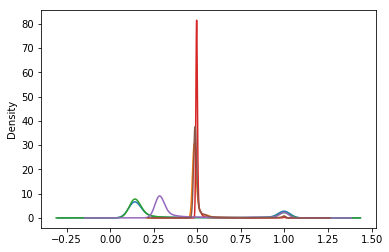

In [137]:
for target in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    print(scores_stacked[target].plot.density())

In [138]:
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'